In [386]:
#### FOR HANDHELD DATA 

import matplotlib.pyplot as plt
import ast
import re
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.patches as patches


frames = []
calcs = []
threshold_gyro = 110
threshold_ps = 45
file_index = "0076"
index_avg = 18
bs_gyro = 45
bs_ps = 10
start = 100
dev_size = 3

file_name = f"../merge/merge_data/merge_data_{file_index}.txt"

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12
fs = 12

def modify_data(data, expected_length=1):

    # # for handheld data 
    serial_data = ast.literal_eval(data)
    data = serial_data[100:len(serial_data)]
    valid_data = list(map(list, zip(*data)))
    print(valid_data)

    return valid_data

def find_min_max_y(serial_data):
    y_max = []
    y_min = []

    max, _ = find_peaks(serial_data, prominence=5, distance=1000)
    min, _ = find_peaks(-np.array(serial_data), prominence = 5, distance=650)

    for i in range(len(max)):
        y_max.append(serial_data[max[i]])

    for i in range(len(min)):
        y_min.append(serial_data[min[i]])
    
    return min, max, y_min, y_max

def deviation(dev):
    dev_list = []
    for i in range(bs_ps-1):
        dev_list.append(0)

    for i in range(bs_ps, len(dev)+1): 
        temp = []
        for j in range(bs_ps):
            temp.append(dev[(i-bs_ps)+j])
        dev_list.append(temp)

    return dev_list

def sum_reed(data_transposed):
    f0 = data_transposed[4]
    f1 = data_transposed[5]
    b0 = data_transposed[6]
    b1 = data_transposed[7]
    reed_sum = []
    
    for i in range(len(f0)):
        reed_sum.append(f0[i]+f1[i]+b0[i]+b1[i])
    return reed_sum

def determine_laser_state_dev_ps(dev_list):
    laser_state_dev = []
    for i in range(bs_ps-1):
        laser_state_dev.append(0)

    dev_list = dev_list[bs_ps-1:len(dev_list)]
    
    for row in dev_list:
        if all(-(dev_size) <= value <= dev_size for value in row):
            laser_state_dev.append(1)
        else:
            laser_state_dev.append(0)

    return laser_state_dev

def determine_laser_gyro(acc_vec):
    laser_state = []

    # such that all minima are found
    for i in range(2):
        laser_state.append(1)

    for i in range(len(acc_vec)-4):
        temp = acc_vec[i:i+bs_gyro]

        # all values need to be inbetween |threshold|
        if all(-threshold_gyro < t < threshold_gyro for t in temp):
            laser_state.append(1)
        else:
            laser_state.append(0)

    for i in range(2):
        laser_state.append(1)

    return laser_state

def determine_laser_pt(laser_state_dev, average, threshold_ps):
    laser_state = []

    for i in range(len(average)):
        if ((average[i] < threshold_ps) and (laser_state_dev[i] == 1)):
            laser_state.append(1)
        else:   
            laser_state.append(0)

    return laser_state 

def determine_laser_reed(data_transposed):
    f0 = data_transposed[4]
    f1 = data_transposed[5]
    b0 = data_transposed[6]
    b1 = data_transposed[7]
    laser_state_reed = []
    for i in range(len(f0)):
        if f0[i] == f1[i] == b0[i] == b1[i] == 1:
            laser_state_reed.append(1)
        else:
            laser_state_reed.append(0)
    return laser_state_reed

def find_laser_rect(laser_state,index):
    start_on = [index[i] for i in range(1, len(laser_state)) if laser_state[i] == 1 and laser_state[i-1] == 0]
    end_on = [index[i] for i in range(1, len(laser_state)) if laser_state[i] == 0 and laser_state[i-1] == 1]

    if (start_on[0] > end_on[0]):
        start_on = [0] + start_on

    if len(start_on) != len(end_on):
        end_on.append(len(laser_state))

    return start_on, end_on

def compare_laser(laser_state_gyro, laser_state_pt):
    laser_comp = []
    for i in range(len(laser_state_gyro)):
        if laser_state_gyro[i] == laser_state_pt[i]:
            laser_comp.append(0)
        if (laser_state_gyro[i] == 1) & (laser_state_pt[i] == 0):
            laser_comp.append(1)        
        if (laser_state_gyro[i] == 0) & (laser_state_pt[i] == 1):
            laser_comp.append(-1)
    return laser_comp

def resulting_laser_state(state_gyro, state_pt, state_reed):
    res_state = []

    for i in range(len(state_gyro)):
        if all([state_gyro[i], state_pt[i], state_reed[i]]):
            res_state.append(1)
        else:
            res_state.append(0)
    return res_state

with open(file_name, "r") as file:
    serial_data = file.read()

data_transposed = modify_data(serial_data)
 
index =  [i for i in range(len(data_transposed[0]))]

### GYRO THINGS
laser_state_gyro = determine_laser_gyro(data_transposed[0])
start_laser_gyro, end_laser_gyro = find_laser_rect(laser_state_gyro, index)

minima_gyro, _ = find_peaks(-np.array(laser_state_gyro))

### PT THINGS
x_min, x_max, y_min, y_max = find_min_max_y(data_transposed[2])
min_pt = { 'index': [i for i in range(len(y_min))],
            'x_min': x_min,
            'y_min': y_min} 
max_pt = { 'index': [i for i in range(len(y_max))],
            'x_max': x_max,
            'y_max': y_max}
   
std_min_pt = np.std(list(y_min))
std_max_pt = np.std(list(y_max))

dev_list = deviation(data_transposed[3])
laser_state_dev = determine_laser_state_dev_ps(dev_list)          # dev übergeben
laser_state_pt = determine_laser_pt(laser_state_dev, data_transposed[2], threshold_ps)     # avg übergeben
start_laser_pt, end_laser_pt = find_laser_rect(laser_state_pt, index)

### REED THINGS
reed_sum = sum_reed(data_transposed)
laser_state_reed = determine_laser_reed(data_transposed)
start_laser_reed, end_laser_reed = find_laser_rect(laser_state_reed, index)

### ALL
laser_comp = compare_laser(laser_state_gyro, laser_state_pt)
result_laser = resulting_laser_state(laser_state_gyro, laser_state_pt, laser_state_gyro)
start_res, end_res = find_laser_rect(result_laser, index)

# [accX, ma_accX, dev_accX, accY, ... , dev_accZ, gyrX, ma_gyrX, dev_gyrX, gyrY, ... , dev_gyrZ, acc_vec, laser_state]
data_all = {'index':index,
            'acc_vec':  data_transposed[0],
            'pt_raw': data_transposed[1],
            'pt_avg': data_transposed[2],
            'pt_dev': data_transposed[3],
            'reedf0': data_transposed[4],
            'reedf1': data_transposed[5],
            'reedb0': data_transposed[6],
            'reedb1': data_transposed[7],
            'reed_sum': reed_sum,
            'laser_gyro': laser_state_gyro,
            'laser_pt': laser_state_pt,
            'laser_reed': laser_state_reed,
            'laser_comp': laser_comp,
            'laser_result': result_laser}

pd_all = pd.DataFrame(data = data_all)      
pd_min_pt = pd.DataFrame(data=min_pt)
pd_max_pt = pd.DataFrame(data=max_pt) 
            
# 0 file_index, 1 pd_all, 2 minima_gyro, 3 min_pt, 4 max_pt, 
# 5 std_min_pt, 6 std_max_pt, 7 start_laser_gyro, 8 end_laser_gyro, 
# 9 start_laser_pt, 10 end_laser_pt, 11 start_laser_reed, 12 end_laser_reed
# 13 start_res, 14 end_res
frames.append([file_index, pd_all, minima_gyro, min_pt, max_pt, std_min_pt, std_max_pt, start_laser_gyro, end_laser_gyro, start_laser_pt, end_laser_pt, start_laser_reed, end_laser_reed, start_res, end_res])




[[-9.0, 12.0, 89.0, 126.0, 57.0, 17.0, 45.0, 102.0, 130.0, 199.0, 203.0, 185.0, 159.0, 158.0, 61.0, 17.0, -73.0, -152.0, -221.0, -186.0, -161.0, -122.0, -173.0, -250.0, -322.0, -356.0, -358.0, -256.0, -54.0, 133.0, 479.0, 755.0, 922.0, 813.0, 818.0, 455.0, -81.0, -383.0, -471.0, -620.0, -653.0, -399.0, -357.0, -326.0, -427.0, -485.0, -734.0, -773.0, -633.0, -321.0, 65.0, 635.0, 966.0, 954.0, 846.0, 635.0, 286.0, -78.0, -147.0, -307.0, -451.0, -493.0, -393.0, -418.0, -657.0, -412.0, -227.0, -14.0, 192.0, 532.0, 388.0, 224.0, 167.0, 115.0, 170.0, 273.0, 388.0, 410.0, 428.0, 402.0, 313.0, 151.0, -28.0, -246.0, -382.0, -387.0, -319.0, -251.0, -13.0, 86.0, 196.0, 350.0, 510.0, 526.0, 538.0, 433.0, 253.0, -36.0, -343.0, -612.0, -749.0, -785.0, -645.0, -418.0, -214.0, -30.0, 34.0, 29.0, 66.0, 190.0, 216.0, 179.0, 365.0, 429.0, 353.0, 294.0, 328.0, 56.0, -127.0, -234.0, -336.0, -370.0, -318.0, -190.0, -82.0, 19.0, 78.0, 72.0, 2.0, 9.0, -34.0, -5.0, 41.0, 128.0, 145.0, 146.0, 5.0, -79.0, -261.0

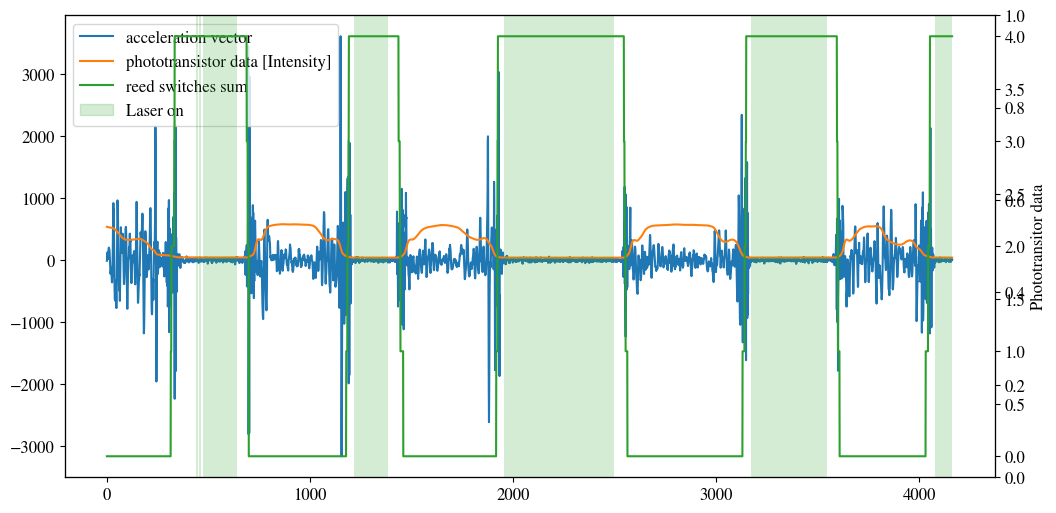

In [285]:
######## from 0012 on ##########

fig, ax = plt.subplots(figsize=(12,6))
ax2 = ax.twinx()
ax3 = ax.twinx()

#end = len(stage_data)
end = len(data_transposed[0])
x = [i for i in range(end)]

plt.xlabel('Position')
plt.ylabel('Phototransitor data')

ax.plot(pd_all.index, pd_all.acc_vec, color = 'C0', label = "acceleration vector")
ax.plot(pd_all.index, pd_all.pt_avg, color = 'C1', label = "phototransistor data [Intensity]")
ax.plot([], [], color = 'C2', label = "reed switches sum")
ax.fill_between([],[],color='C2', alpha=0.2, label = 'Laser on')
ax2.plot(pd_all.index, pd_all.reed_sum, color = 'C2', label = "reed switches sum")


# s_gyro = frames[0][7]
# e_gyro = frames[0][8]
# for j in range(len(s_gyro)):          
#     ax2.add_patch(patches.Rectangle((s_gyro[j], -10000), e_gyro[j]-s_gyro[j], 25500, linewidth=0,  color='C0', alpha=0.2)) 

# s_pt = frames[0][9]
# e_pt = frames[0][10]
# for j in range(len(s_pt)):            
#     ax2.add_patch(patches.Rectangle((s_pt[j], -10000), e_pt[j]-s_pt[j], 25500, linewidth=0,  color='C1', alpha=0.2)) 

# s_reed = frames[0][11]
# e_reed = frames[0][12]
# for j in range(len(s_reed)):         
#     ax.add_patch(patches.Rectangle((s_reed[j], -10000), e_reed[j]-s_reed[j], 25500, linewidth=0,  color='C2', alpha=0.2)) 

s_res = frames[0][13]
e_res = frames[0][14]
for j in range(len(s_res)):         
    ax3.add_patch(patches.Rectangle((s_res[j], -10000), e_res[j]-s_res[j], 25500, linewidth=0,  color='C2', alpha=0.2)) 

ax.legend(loc="upper left")

C:\Users\Anna\AppData\Local\Temp\ipykernel_12772\864842838.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)
C:\Users\Anna\AppData\Local\Temp\ipykernel_12772\864842838.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)
C:\Users\Anna\AppData\Local\Temp\ipykernel_12772\864842838.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)
C:\Users\Anna\AppData\Local\Temp\ipykernel_12772\864842838.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)


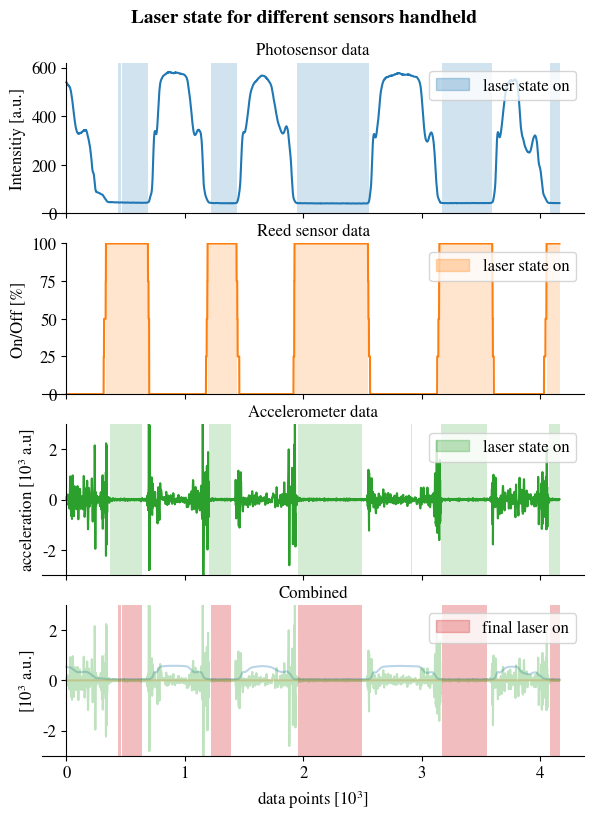

In [387]:
### 4x1 handheld plot all 
fig, axs = plt.subplots(4,1, figsize=(7,9))
fig.text(0.5,0.93, 'Laser state for different sensors handheld', va='center', ha='center', rotation='horizontal', fontsize=fs+2, weight='bold')
fs = 12
plt.rcParams['font.size'] = 12

for i, ax in enumerate(axs.flatten()):
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines['left'].set_position('zero')

    # PT
    if i == 0:
        s_pt = frames[0][9]
        e_pt = frames[0][10]

        ax.plot(pd_all.index, pd_all.pt_avg, color = 'C0')
        ax.fill_between([],[], color = 'C0', label = "laser state on", alpha = 0.3)
        
        for j in range(len(s_pt)):            
            ax.add_patch(patches.Rectangle((s_pt[j], 0), e_pt[j]-s_pt[j], 620, linewidth=0,  color='C0', alpha=0.2)) 
        
        ax.set_ylim([0,620])
        ax.set_xticklabels([])
        ax.set(ylabel='Intensitiy [a.u.]')
        ax.set_title('Photosensor data', fontsize = fs)

    # Reed
    elif i == 1:
        s_reed = frames[0][11]
        e_reed = frames[0][12]

        ax.plot(pd_all.index, pd_all.reed_sum, color = 'C1')
        ax.fill_between([],[], color = 'C1', label = "laser state on", alpha = 0.3)

        for j in range(len(s_reed)):         
            ax.add_patch(patches.Rectangle((s_reed[j], 0), e_reed[j]-s_reed[j], 4, linewidth=0,  color='C1', alpha=0.2)) 
        
        ax.set_ylim([0,4])
        ylabels = ['{:,.0f}'.format(y) for y in ax.get_yticks()*25]
        ax.set_yticklabels(ylabels)
        ax.set_xticklabels([])
        ax.set(ylabel='On/Off [%]')
        ax.set_title('Reed sensor data', fontsize = fs)

    # Gyro
    elif i == 2:
        s_gyro = frames[0][7]
        e_gyro = frames[0][8]

        ax.plot(pd_all.index, pd_all.acc_vec, color = 'C2')
        ax.fill_between([],[], color = 'C2', label = "laser state on", alpha = 0.3)

        for j in range(len(s_gyro)):          
            ax.add_patch(patches.Rectangle((s_gyro[j], -3000), e_gyro[j]-s_gyro[j], 6000, linewidth=0,  color='C2', alpha=0.2))
    
        ax.set_ylim([-3000,3000])
        ylabels = ['{:,.0f}'.format(y) for y in ax.get_yticks()/1000]
        ax.set_yticklabels(ylabels)
        ax.set_xticklabels([])
        ax.set(ylabel='acceleration [$10^3$ a.u]')
        ax.set_title('Accelerometer data', fontsize = fs)

    # All
    elif i == 3:
        s_res = frames[0][13]
        e_res = frames[0][14]

        ax.plot(pd_all.index, pd_all.pt_avg, color = 'C0', alpha = 0.3)
        ax.plot(pd_all.index, pd_all.reed_sum, color = 'C1', alpha = 0.3)
        ax.plot(pd_all.index, pd_all.acc_vec, color = 'C2', alpha = 0.3)
        ax.fill_between([],[], color = 'C3', alpha = 0.3, label = 'final laser on')

        for j in range(len(s_res)):         
            ax.add_patch(patches.Rectangle((s_res[j], -3000), e_res[j]-s_res[j], 6000, linewidth=0,  color='C3', alpha=0.3)) 

        ax.set_ylim([-3000,3000])
        ylabels = ['{:,.0f}'.format(y) for y in ax.get_yticks()/1000]
        ax.set_yticklabels(ylabels)        
        xlabels = ['{:,.0f}'.format(y) for y in ax.get_xticks()/1000]
        ax.set_xticklabels(xlabels)
        ax.set(xlabel='data points $[10^3]$', ylabel='[$10^3$ a.u.]' )
        ax.set_title('Combined', fontsize = fs)

    ax.legend(loc = "upper right")
    

name_file = f"All_data_4x1_plot_handheld_{file_index}"
plt.savefig(f"../../../LaTex/Master Thesis/figures/{name_file}.pdf")
plt.savefig(f"../../../LaTex/Master Thesis/figures/{name_file}.png")
plt.savefig(f"../../../LaTex/Master Thesis/figures/{name_file}.svg")

In [388]:
#### FOR STAGE DATA 

import matplotlib.pyplot as plt
import ast
import re
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.patches as patches

frames = []
calcs = []
threshold_gyro = 110
threshold_ps = 45
file_index = "0078"
index_avg = 18
bs_gyro = 45
bs_ps = 10
start = 100
dev_size = 3
end_stage = 48

file_name = f"../merge/merge_data/merge_data_{file_index}.txt"

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12
fs = 12

def modify_data(data, expected_length=1):

    # for stage data 
    data = ast.literal_eval(data)

    converted_data = []
    for outer in data:
        temp = [outer[0]]  # Keep the first element as it is (already a float)
        try:
            temp.extend(float(inner) for inner in outer[1])  # Convert inner list elements to float and extend the temp list
        except ValueError:
            continue
        converted_data.append(temp)

    # check for invalid entries
    valid_data = []
    invalid_entries = []
    for i, entry in enumerate(converted_data):
        if len(entry) == 9:
            # Check if all elements can be converted to float
            try:
                temp = [float(entry[0])] + [float(x) for x in entry[1:]]
                valid_data.append(temp)
            except ValueError:
                invalid_entries.append(i)
        else:
            invalid_entries.append(i)

    data = valid_data[100:len(valid_data)]
    valid_data = list(map(list, zip(*data)))
    return valid_data

def find_min_max_y(serial_data):
    y_max = []
    y_min = []

    max, _ = find_peaks(serial_data, prominence=5, distance=1000)
    min, _ = find_peaks(-np.array(serial_data), prominence = 5, distance=650)

    for i in range(len(max)):
        y_max.append(serial_data[max[i]])

    for i in range(len(min)):
        y_min.append(serial_data[min[i]])
    
    return min, max, y_min, y_max

def deviation(dev):
    dev_list = []
    for i in range(bs_ps-1):
        dev_list.append(0)

    for i in range(bs_ps, len(dev)+1): 
        temp = []
        for j in range(bs_ps):
            temp.append(dev[(i-bs_ps)+j])
        dev_list.append(temp)

    return dev_list

def sum_reed(data_transposed):
    f0 = data_transposed[5]
    f1 = data_transposed[6]
    b0 = data_transposed[7]
    b1 = data_transposed[8]
    reed_sum = []
    
    for i in range(len(f0)):
        reed_sum.append(f0[i]+f1[i]+b0[i]+b1[i])
    return reed_sum

def determine_laser_state_dev_ps(dev_list):
    laser_state_dev = []
    for i in range(bs_ps-1):
        laser_state_dev.append(0)

    dev_list = dev_list[bs_ps-1:len(dev_list)]
    
    for row in dev_list:
        if all(-(dev_size) <= value <= dev_size for value in row):
            laser_state_dev.append(1)
        else:
            laser_state_dev.append(0)

    return laser_state_dev

def determine_laser_gyro(acc_vec):
    laser_state = []

    # such that all minima are found
    for i in range(2):
        laser_state.append(1)

    for i in range(len(acc_vec)-4):
        temp = acc_vec[i:i+bs_gyro]

        # all values need to be inbetween |threshold|
        if all(-threshold_gyro < t < threshold_gyro for t in temp):
            laser_state.append(1)
        else:
            laser_state.append(0)

    for i in range(2):
        laser_state.append(1)

    return laser_state

def determine_laser_pt(laser_state_dev, average, threshold_ps):
    laser_state = []

    for i in range(len(average)):
        if ((average[i] < threshold_ps) and (laser_state_dev[i] == 1)):
            laser_state.append(1)
        else:   
            laser_state.append(0)

    return laser_state 

def determine_laser_reed(reed_sum):

    laser_state_reed = []
    for i in range(len(reed_sum)):
        if reed_sum[i] == 4:
            laser_state_reed.append(1)
        else:
            laser_state_reed.append(0)
    return laser_state_reed

def find_laser_rect(laser_state,index):
    start_on = [index[i] for i in range(1, len(laser_state)) if laser_state[i] == 1 and laser_state[i-1] == 0]
    end_on = [index[i] for i in range(1, len(laser_state)) if laser_state[i] == 0 and laser_state[i-1] == 1]

    if (start_on[0] > end_on[0]):
        start_on = [0] + start_on

    if len(start_on) != len(end_on):
        end_on.append(len(laser_state))

    return start_on, end_on

def compare_laser(laser_state_gyro, laser_state_pt):
    laser_comp = []
    for i in range(len(laser_state_gyro)):
        if laser_state_gyro[i] == laser_state_pt[i]:
            laser_comp.append(0)
        if (laser_state_gyro[i] == 1) & (laser_state_pt[i] == 0):
            laser_comp.append(1)        
        if (laser_state_gyro[i] == 0) & (laser_state_pt[i] == 1):
            laser_comp.append(-1)
    return laser_comp

def resulting_laser_state(state_pt, state_reed):
    res_state = []

    for i in range(len(state_pt)):
        if all([state_pt[i], state_reed[i]]):
            res_state.append(1)
        else:
            res_state.append(0)
    return res_state

def make_bins(position_data, sensor_data):
# Parameters
    bin_count = 192                # how many bins 
    position_range = (-end_stage,0)        # range of position data
    bin_width = -position_range[0]/bin_count    # how big is one bin
    bins = np.zeros(bin_count)

# Process data
    for pos, sensor in zip(position_data, sensor_data):
        if position_range[0] <= pos <= position_range[1]:
            bin_index = int((pos - position_range[0]) / bin_width)
            bins[bin_index] += sensor

    bins = bins[0:bin_count-1]          # cutoff last one because still
    max_count = bins.max()
    normalized_bins=np.round((bins / max_count) * 10 ,1)    # round to one digit (otherwise to many bins after normalizing, normalize to #rounds*2)

    x_bins = np.linspace(-end_stage,0,bin_count-1)   # find x values for bin_count

    return x_bins, normalized_bins




with open(file_name, "r") as file:
    serial_data = file.read()

data_transposed = modify_data(serial_data)
data_transposed[0]  =  list((np.array(data_transposed[0]) - 48))

index =  [i for i in range(len(data_transposed[0]))]

### GYRO THINGS
laser_state_gyro = determine_laser_gyro(data_transposed[1])
start_laser_gyro, end_laser_gyro = find_laser_rect(laser_state_gyro, index)

minima_gyro, _ = find_peaks(-np.array(laser_state_gyro))

### PT THINGS
x_min, x_max, y_min, y_max = find_min_max_y(data_transposed[2])
min_pt = { 'index': [i for i in range(len(y_min))],
            'x_min': x_min,
            'y_min': y_min} 
max_pt = { 'index': [i for i in range(len(y_max))],
            'x_max': x_max,
            'y_max': y_max}
   
std_min_pt = np.std(list(y_min))
std_max_pt = np.std(list(y_max))

dev_list = deviation(data_transposed[4])
laser_state_dev = determine_laser_state_dev_ps(dev_list)          # dev übergeben
laser_state_pt = determine_laser_pt(laser_state_dev, data_transposed[3], threshold_ps)     # avg übergeben
start_laser_pt, end_laser_pt = find_laser_rect(laser_state_pt, index)
x_bins_pt, norm_bins_pt = make_bins(data_transposed[0], laser_state_pt)
print(norm_bins_pt)

### REED THINGS
reed_sum = sum_reed(data_transposed)
laser_state_reed = determine_laser_reed(reed_sum)
start_laser_reed, end_laser_reed = find_laser_rect(laser_state_reed, index)
x_bins_reed, norm_bins_reed = make_bins(data_transposed[0], laser_state_reed)
print(norm_bins_reed)

### ALL
laser_comp = compare_laser(laser_state_gyro, laser_state_pt)
# result_laser = resulting_laser_state(laser_state_gyro, laser_state_pt, laser_state_gyro)
result_laser = resulting_laser_state(laser_state_pt, laser_state_gyro)
start_res, end_res = find_laser_rect(result_laser, index)

# [accX, ma_accX, dev_accX, accY, ... , dev_accZ, gyrX, ma_gyrX, dev_gyrX, gyrY, ... , dev_gyrZ, acc_vec, laser_state]
data_all = {'index':index,
            'position': data_transposed[0],
            'acc_vec':  data_transposed[1],
            'pt_raw': data_transposed[2],
            'pt_avg': data_transposed[3],
            'pt_dev': data_transposed[4],
            'reedf0': data_transposed[5],
            'reedf1': data_transposed[6],
            'reedb0': data_transposed[7],
            'reedb1': data_transposed[8],
            'reed_sum': reed_sum,
           # 'laser_gyro': laser_state_gyro,
            'laser_pt': laser_state_pt,
            'laser_reed': laser_state_reed,
            'laser_comp': laser_comp,
            'laser_result': result_laser}

pd_all = pd.DataFrame(data = data_all)      
pd_min_pt = pd.DataFrame(data=min_pt)
pd_max_pt = pd.DataFrame(data=max_pt) 
            
# 0 file_index, 1 pd_all, 2 minima_gyro, 3 min_pt, 4 max_pt, 
# 5 std_min_pt, 6 std_max_pt, 7 start_laser_gyro, 8 end_laser_gyro, 
# 9 start_laser_pt, 10 end_laser_pt, 11 start_laser_reed, 12 end_laser_reed
# 13 start_res, 14 end_res
frames.append([file_index, pd_all, minima_gyro, min_pt, max_pt, std_min_pt, std_max_pt, start_laser_gyro, end_laser_gyro, start_laser_pt, end_laser_pt, start_laser_reed, end_laser_reed, start_res, end_res])


[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   5.  10.
  6.2  6.2  7.5  7.5  8.8  7.5  6.2  7.5 10. ]
[ 0.   0.   0.   0.   0.   0.   0.   0.   0

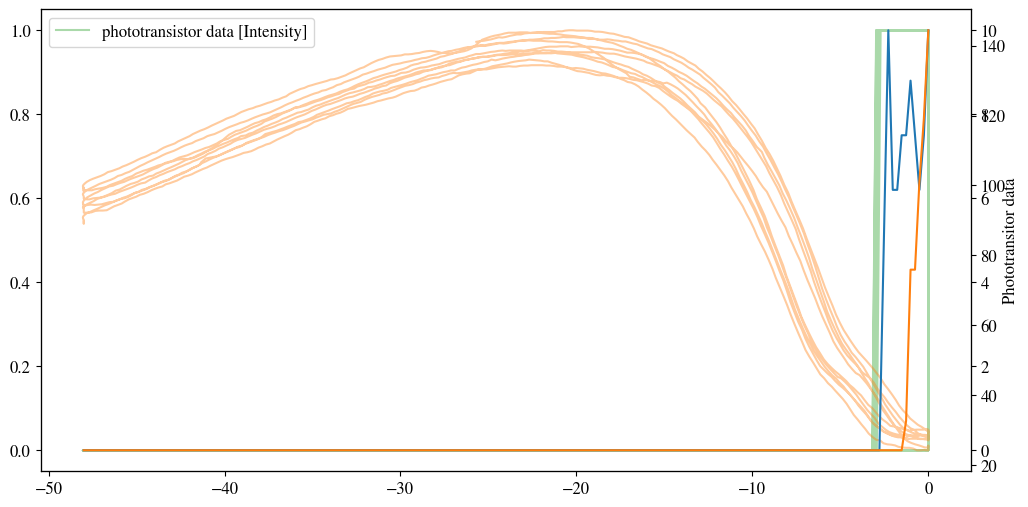

In [374]:

fig, ax = plt.subplots(figsize=(12,6))
ax2 = ax.twinx()
ax3 = ax.twinx()

#end = len(stage_data)
start = 100
end = len(data_transposed[0])
x = [i for i in range(end)]

plt.xlabel('Position')
plt.ylabel('Phototransitor data')

#plt.xlim([-20,0])
# ax.plot(pd_all.position, pd_all.reed_sum, color = 'C0', alpha = 0.4, label = "Reed data")
# ax3.plot(x_bins_reed, norm_bins_reed)


ax2.plot(pd_all.position, pd_all.pt_avg, color = 'C1', alpha = 0.4, label = "phototransistor data [Intensity]")
ax.plot(pd_all.position, pd_all.laser_pt, color = 'C2', alpha = 0.4, label = "phototransistor data [Intensity]")
ax3.plot(x_bins_pt, norm_bins_pt)
ax3.plot(x_bins_reed, norm_bins_reed)

#ax3.plot(x_bins_reed[0:len(x_bins_reed)-1], norm_bins_reed[0:len(x_bins_reed)-1])
#ax3.set_ylim([0,50])
#ax3.plot(pd_all.position, pd_all.laser_reed, color = 'C0', label = "Reed data")
# ax3.plot(pd_all.position, pd_all.laser_pt, color = 'C1', label = 'Laser PT')
# ax.plot(pd_all.position, pd_all.laser_reed, color = 'C2', alpha = 0.5, label = 'Laser Reed')
# ax.plot(pd_all.position, pd_all.reed_sum, color = 'C1', alpha = 0.5, label = 'Laser Reed')



# s_gyro = frames[0][7]
# e_gyro = frames[0][8]
# for j in range(len(s_gyro)):          
#     ax2.add_patch(patches.Rectangle((s_gyro[j], -10000), e_gyro[j]-s_gyro[j], 25500, linewidth=0,  color='C0', alpha=0.2)) 

# s_pt = frames[0][9]
# e_pt = frames[0][10]
# for j in range(len(s_pt)):            
#     ax2.add_patch(patches.Rectangle((s_pt[j], -10000), e_pt[j]-s_pt[j], 25500, linewidth=0,  color='C1', alpha=0.2)) 

# s_reed = frames[0][11]
# e_reed = frames[0][12]
# for j in range(len(s_reed)):         
#     ax.add_patch(patches.Rectangle((s_reed[j], -10000), e_reed[j]-s_reed[j], 25500, linewidth=0,  color='C2', alpha=0.2)) 

# s_res = frames[0][13]
# e_res = frames[0][14]
# for j in range(len(s_res)):         
#     ax3.add_patch(patches.Rectangle((s_res[j], -10000), e_res[j]-s_res[j], 25500, linewidth=0,  color='C2', alpha=0.2)) 

ax.legend(loc="upper left")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Anna\AppData\Local\Temp\ipykernel_12772\719672171.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


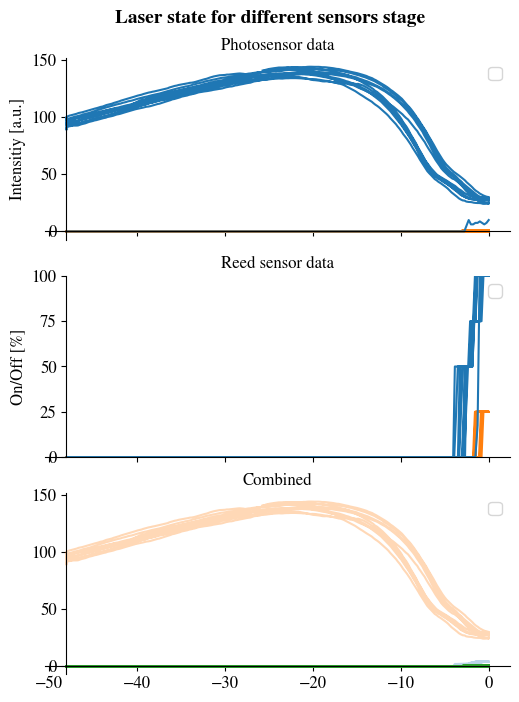

In [391]:
### 3x1 stage plot all 
#define dpi?
fig, axs = plt.subplots(3,1, figsize=(6,8))
fig.text(0.5,0.93, 'Laser state for different sensors stage', va='center', ha='center', rotation='horizontal', fontsize=fs+2, weight='bold')
fs = 12
plt.rcParams['font.size'] = 12

for i, ax in enumerate(axs.flatten()):
    ax.spines[['top', 'right']].set_visible(False)

    ax.spines['left'].set_position(('data', -48))
    ax.spines['bottom'].set_position(('data', 0))    
    #ax.spines['right'].set_position(('data', 0))


# ax2.plot(pd_all.position, pd_all.pt_avg, color = 'C1', alpha = 0.4, label = "phototransistor data [Intensity]")
# ax.plot(pd_all.position, pd_all.laser_pt, color = 'C2', alpha = 0.4, label = "phototransistor data [Intensity]")
# ax3.plot(x_bins_pt, norm_bins_pt)
# ax3.plot(x_bins_reed, norm_bins_reed)




    # PT
    if i == 0:
        ax.plot(pd_all.position, pd_all.pt_avg, color = 'C0')
        ax.plot(pd_all.position, pd_all.laser_pt, color = 'C1')
        ax.plot(x_bins_pt, norm_bins_pt)

        ax.set_xticklabels([])
        ax.set(ylabel='Intensitiy [a.u.]')
        ax.set_title('Photosensor data', fontsize = fs)

    # Reed
    elif i == 1:
        ax.plot(pd_all.position, pd_all.reed_sum, color = 'C0')
        ax.plot(pd_all.position, pd_all.laser_reed, color = 'C1')
        ax.plot(x_bins_reed, norm_bins_reed)

        ax.set_ylim([0,4])
        ylabels = ['{:,.0f}'.format(y) for y in ax.get_yticks()*25]
        ax.set_yticklabels(ylabels)
        ax.set_xticklabels([])
        ax.set(ylabel='On/Off [%]')
        ax.set_title('Reed sensor data', fontsize = fs)

    # All
    elif i == 2:
        ax.plot(pd_all.position, pd_all.reed_sum, color = 'C0', alpha = 0.3)
        ax.plot(pd_all.position, pd_all.pt_avg, color = 'C1', alpha = 0.3)
        ax.plot(pd_all.position, pd_all.laser_result, color = 'C2')
        # ax.plot(x_bins_result norm_bins_result)

        ax.set_title('Combined', fontsize = fs)

    ax.legend(loc = "upper right")
    

name_file = f"All_data_4x1_plot_stage_{file_index}"
plt.savefig(f"../../../LaTex/Master Thesis/figures/{name_file}.pdf")
plt.savefig(f"../../../LaTex/Master Thesis/figures/{name_file}.png")
plt.savefig(f"../../../LaTex/Master Thesis/figures/{name_file}.svg")